In [ ]:
%load_ext memory_profiler

import numpy as np

import scipy
import scipy.sparse as sparse
import scipy.io as io

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import scanpy as sc

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import LeaveOneOut, cross_val_score
from sklearn.metrics import f1_score, silhouette_score, silhouette_samples

from openTSNE import TSNE

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


In [ ]:
meta = pd.read_csv('../datasets/pbmc_ssc/meta.csv', index_col=0)

# sort data by batch
batch_label = pd.factorize(meta.Method)[0]
idx_reorder = batch_label.argsort()
blab_reorder = batch_label[idx_reorder]
ct_reorder = meta.CellType.values[idx_reorder]

name = 'pbmcssc'
pca_glmpca = pd.read_csv('../fastrna_r/pca_coord/%s/pca_glmpca_nobatch.csv' % name, index_col=0).values[idx_reorder,:]
pca_logpca = pd.read_csv('../fastrna_r/pca_coord/%s/pca_log_nobatch.csv' % name, index_col=0).values[idx_reorder,:]



In [ ]:
sils = []
Xs = [pca_glmpca[:,:50], pca_logpca[:,:50]]
labels = [ct_reorder] * len(Xs)

for X, lab in zip(Xs, labels):
    sils.append(silhouette_samples(X, lab, metric='cosine'))
sils

In [ ]:
scores =[]
for X, lab in zip(Xs, labels):
    labels = pd.factorize(lab)[0]
    k=5
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, X, labels, cv=5, scoring='accuracy')
    scores.append(score)
    
scores

In [ ]:
sils_b = []
Xs = [pca_glmpca[:,:50], pca_logpca[:,:50]]
labels = [blab_reorder] * len(Xs)
for X, lab in zip(Xs, labels):
    sils_b.append(silhouette_samples(X, lab, metric='cosine'))
sils_b

In [6]:
import matplotlib
matplotlib.rcParams['font.sans-serif'] = "Arial"
%config InlineBackend.figure_formats = ['svg']

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(20,6))

df = pd.DataFrame(np.array(sils).T, columns=['LogNorm', 
                                               'GLM-PCA'])
df_melt = pd.melt(df, var_name='Method', value_name='Silhouette score')    
sns.barplot(x='Method', y='Silhouette score', data=df_melt, ax=ax[0],
           edgecolor='black', linewidth=2, capsize=.2, estimator=np.median)

ax[0].set_xlabel(ax[0].get_xlabel(), fontsize=20)
ax[0].set_xticklabels(ax[0].get_xticklabels(), fontsize=18, rotation=20)

ax[0].set_ylabel(ax[0].get_ylabel() + ' (Higher is better)', fontsize=18)

ax[0].bar_label(ax[0].containers[0], fontsize=18, padding=10, fmt='%.3f')
ax[0].set_ylim([0,0.6])
ax[0].set_title('', fontsize=18, va='bottom')
ax[0].set_xlabel('')
ax[0].text(0.05, 0.9, 'No batch correction', fontsize=20, transform=ax[0].transAxes)

df = pd.DataFrame(np.array(scores).T, columns=['LogNorm', 
                                               'GLM-PCA'])
df_melt = pd.melt(df, var_name='Method', value_name='5-fold CV score')        
sns.barplot(x='Method', y='5-fold CV score', data=df_melt, ax=ax[1],
           edgecolor='black', linewidth=2, capsize=.2)

ax[1].set_xlabel(ax[1].get_xlabel(), fontsize=20)
ax[1].set_xticklabels(ax[1].get_xticklabels(), fontsize=18, rotation=20)

ax[1].set_ylabel(ax[1].get_ylabel() + ' (Higher is better)', fontsize=18)

ax[1].bar_label(ax[1].containers[0], fontsize=18, padding=10, fmt='%.3f')
ax[1].set_ylim([0,1.1])
ax[1].set_title('', fontsize=18, va='bottom')
ax[1].set_xlabel('')

df = pd.DataFrame(np.abs(np.array(sils_b).T), columns=['LogNorm', 
                                               'GLM-PCA'])
df_melt = pd.melt(df, var_name='Method', value_name='Batch silhouette score')        
sns.barplot(x='Method', y='Batch silhouette score', data=df_melt, ax=ax[2],
           edgecolor='black', linewidth=2, capsize=.2, estimator=np.median)

ax[2].set_xlabel(ax[2].get_xlabel(), fontsize=20)
ax[2].set_xticklabels(ax[2].get_xticklabels(), fontsize=18, rotation=20)

ax[2].set_ylabel(ax[2].get_ylabel() + ' (Lower is better)', fontsize=18)

ax[2].bar_label(ax[2].containers[0], fontsize=18, padding=10, fmt='%.3f')
ax[2].set_ylim([0,0.13])
ax[2].set_title('', fontsize=18, va='bottom')
ax[2].set_xlabel('')

plt.show()

In [ ]:
def tsne_for_pca(pca):
    fig, ax = plt.subplots(1, 2, figsize=(14, 6.5))
    np.random.seed(0)
    tsne = TSNE(n_jobs=16, perplexity=30, exaggeration=2, initialization=pca[:,:2]).fit(pca[:,:])

    scatter = sns.scatterplot(x=tsne[:,0], y=tsne[:,1], 
                    s=5, 
                    hue=ct_reorder, 
                    edgecolor='none', 
                    legend=True,
                    ax=ax[0],
                    palette='tab10', rasterized=True
                    )
    sns.scatterplot(x=tsne[:,0], y=tsne[:,1], 
                    s=5, 
                    hue=blab_reorder, 
                    edgecolor='none', 
                    legend=False,
                    ax=ax[1],
                    palette='cividis', rasterized=True
                    )

    ax[0].legend().set_visible(False)

    handles0, labels0 = ax[0].get_legend_handles_labels()
    legend = fig.legend(handles0, 
               labels0, 
               bbox_to_anchor=(0.5,0.05), 
               loc='upper center', 
               ncol=2, 
               fontsize=18, 
               frameon=False)

    legend.set_title('Cell-types', prop={'size':20})

    ax[0].set_title('Colored-by-celltype', fontsize=15)
    ax[1].set_title('Colored-by-batch', fontsize=15)


    plt.show()
    return tsne

In [ ]:
tsne_glmpca = tsne_for_pca(pca_glmpca)

In [ ]:
tsne_logpca = tsne_for_pca(pca_logpca)

# Runtime - pbmcssc

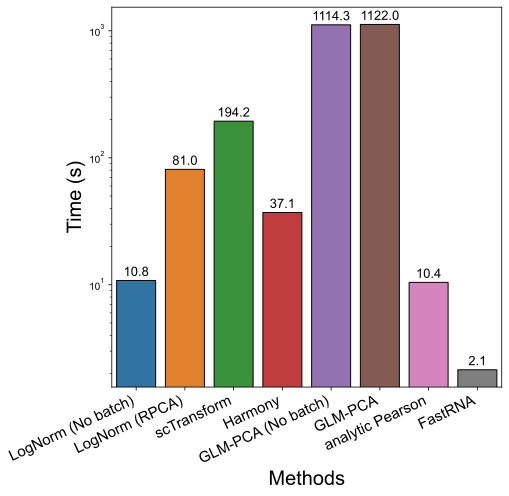

In [7]:
names = ['LogNorm (No batch)', 'LogNorm (RPCA)', 'scTransform', 'Harmony',
        'GLM-PCA (No batch)', 'GLM-PCA', 'analytic Pearson', 'FastRNA']
times = [10.804, 81.031, 194.176, 37.08, 
        1114.301, 1121.989, 10.434, 2.139]

fig, ax = plt.subplots(figsize=(7,7))
df_time = pd.DataFrame({'Methods': names, 'Time (s)': times})
sns.barplot(x='Methods', y='Time (s)', data=df_time, edgecolor='black')

ax.set_xlabel(ax.get_xlabel(), fontsize=20)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=15, rotation=25, ha='right')
ax.set_ylabel(ax.get_ylabel(), fontsize=20)
ax.set_yscale('log')
ax.bar_label(ax.containers[0], fontsize=13, padding=2, fmt='%.1f')

plt.show()